In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('algerian.txt' ,header=None)
df['Year']=pd.RangeIndex(start=1960,stop=1960+len(df))
df.set_index('Year',inplace=True)
df.columns=['Export']
df.asfreq('YS')
df

,Export
Year,
1960,39.043173
1961,46.244557
1962,19.793873
1963,24.684682
1964,25.084059
1965,22.603944
1966,25.986198
1967,23.434417
1968,23.135635


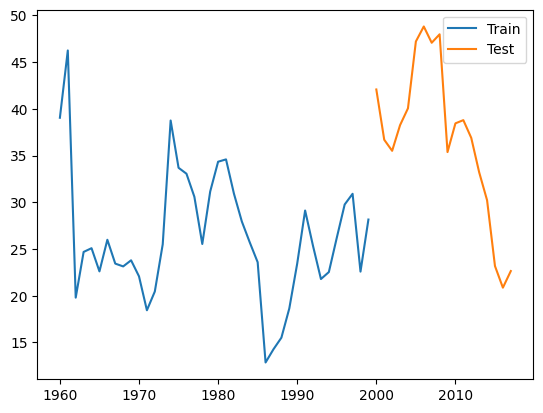

In [139]:
train = df.iloc[0:40]
test = df.iloc[40:]
plt.plot(train['Export'], label='Train')
plt.plot(test['Export'], label='Test')
plt.legend()

Data is prepared and split into train and test. Now I can start with the forecasting methods. For cleaner code, I put all the functions in one section.

In [140]:
def calculate_ses(data:list, initial_level:float, smoothing_level: float):
    """
    Calculate Simple Exponential Smoothing (SES) forecasts for a given time series.

    Args:
        data (list or np.array): The time series data.
        initial_level (float): The initial level value for the SES calculation.
        smoothing_level (float): The smoothing level (alpha) for the SES calculation.

    Returns:
        list: The calculated SES forecasts.
    """
    forecasts = [initial_level]  # list to store
    for time in range(0, len(data) - 1):
        level = smoothing_level * data[time] + (1 - smoothing_level) * forecasts[time]
        forecasts.append(level)
    return forecasts

def calculate_sse(actual_data:list, forecasted_data:list):
    """
    Calculate the sum of squared errors (SSE) between the actual and forecasted data.

    Args:
        actual_data (list or np.array): The actual time series data.
        forecasted_data (list or np.array): The forecasted time series data.

    Returns:
        float: The calculated SSE.
    """
    sum_squared_errors = 0
    for time in range(0, len(actual_data)):
        sum_squared_errors += (actual_data[time] - forecasted_data[time]) ** 2
    return sum_squared_errors

def fit_ses(actual_data:list, smoothing_level:float):
    """
    Fit the SES model to the actual data and find the optimal smoothing level.

    Args:
        actual_data (list or np.array): The actual time series data.
        smoothing_level (float): The initial guess for the smoothing level.

    Returns:
        float: The optimal smoothing level (alpha) for the SES model.
    """
    initial_level = actual_data[0]
    smoothing_levels = np.arange(0,1,0.001)
    sum_squared_errors_array = []
    for alpha in smoothing_levels:
        forecasts = calculate_ses(actual_data, initial_level, alpha)
        sum_squared_errors = calculate_sse(actual_data, forecasts)
        sum_squared_errors_array.append(sum_squared_errors)
    optimal_smoothing_level = smoothing_levels[np.argmin(sum_squared_errors_array)]
    return optimal_smoothing_level


### Simple Exponential Smoothing
I will experiment with two different alpha values to determine the characteristics of this SES model.

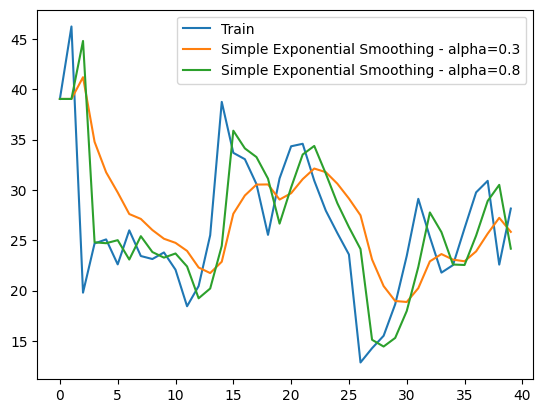

In [141]:
train_values=train['Export'].values
alpha=0.5
l0=train_values[0]
ses_forecasts_alpha1 = calculate_ses(train_values, l0, 0.3)
ses_forecasts_alpha2 = calculate_ses(train_values, l0, 0.8)
plt.plot(train_values, label='Train')
plt.plot(ses_forecasts_alpha1, label='Simple Exponential Smoothing - alpha=0.3')
plt.plot(ses_forecasts_alpha2, label='Simple Exponential Smoothing - alpha=0.8')
plt.legend()

### Quick conclusion
The lower the alpha, the smoother the forecast. The higher the alpha, the more the forecast follows the data.  

Now I will calculate SSE for the two alpha values and find the optimal alpha value.

In [142]:
sse_1= calculate_sse(train_values, ses_forecasts_alpha1)
sse_2= calculate_sse(train_values, ses_forecasts_alpha2)
print(f'SSE for alpha=0.3: {sse_1}')
print(f'SSE for alpha=0.8: {sse_2}')

SSE for alpha=0.3: 1750.7692725663728
SSE for alpha=0.8: 1425.4238665375792


In [143]:
best_alpha = fit_ses(train_values, alpha)
print(f'Optimal alpha: {best_alpha}')

Optimal alpha: 0.757


### Alpha - conclusion
The optimal aplha value appears to be 0.758. Then I can conclude, that my dataset has a high level of randomness. Because of that my SES model has to follow more recent data closely to make accurate forecasts.  

Now I will calculate the forecasts for the test set.

In [144]:
def calculate_forecasts(actual_data, optimal_smoothing_level:float, initial_level:float, forecast_horizon:int):
    """
    Calculate the forecasts for a given time series using the SES model.

    Args:
        actual_data (list or np.array): The actual time series data.
        optimal_smoothing_level (float): The optimal smoothing level (alpha) for the SES model.
        initial_level (float): The initial level value for the SES calculation.
        forecast_horizon (int): The number of future time points to forecast.

    Returns:
        tuple: The final level, the forecasts for the forecast horizon, and the forecasts for the training data.
    """
    forecasts_train = calculate_ses(actual_data, initial_level, optimal_smoothing_level)
    level = forecasts_train[-1]+(1-optimal_smoothing_level)*forecasts_train[-1]
    multiple_levels=[level]*forecast_horizon
    return level, multiple_levels, forecasts_train

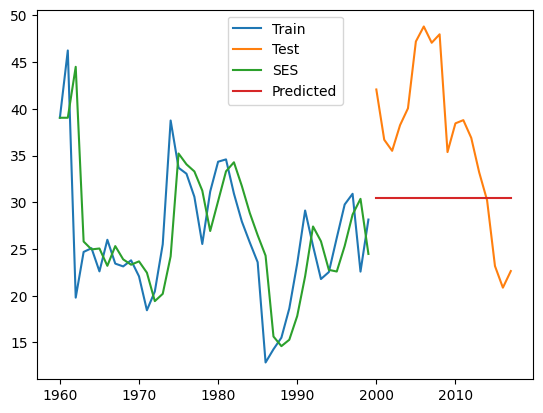

In [145]:
l, multiple_l, forecasts_train = calculate_forecasts(train_values, best_alpha, l0, len(test))
train = train.copy()
test = test.copy()

train.loc[:, 'SES'] = forecasts_train
test.loc[:, 'Predicted'] = multiple_l
plt.plot(train['Export'], label='Train')
plt.plot(test['Export'], label='Test')
plt.plot(train['SES'], label='SES')
plt.plot(test['Predicted'], label='Predicted')
plt.legend()

### Conclusion
The SES model seems to be a good fit for the data. The forecasted values are close to the actual values.

Now I will compare my model with statsmodels SES.


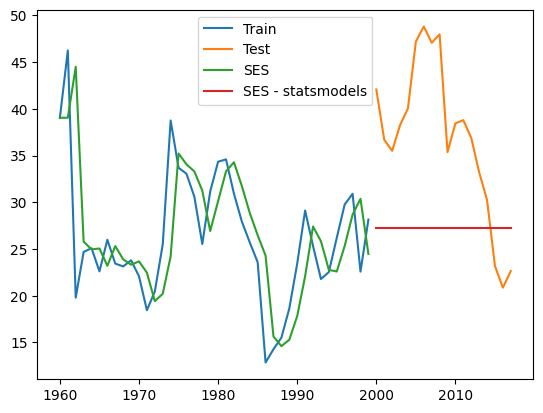

In [146]:
# import simple exponential smoothing model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

train.index = pd.to_datetime(train.index, format='%Y')
test.index = pd.to_datetime(test.index, format='%Y')
train = train.asfreq('YS')
test = test.asfreq('YS')

model = SimpleExpSmoothing(train['Export'])
model_fit = model.fit(smoothing_level=best_alpha, optimized=False)
test['SES'] = model_fit.forecast(len(test))
plt.plot(train['Export'], label='Train')
plt.plot(test['Export'], label='Test')
plt.plot(train['SES'], label='SES')
plt.plot(test['SES'], label='SES - statsmodels')
plt.legend()

### Final conclusion

Appears that my model is very similar to the statsmodels SES. The forecasted values are close to the actual values.